# Field Goals: An Observational Study ⛰️

* Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.
* Hypothesis: Icing a kicker prior to an attempty reduces the likelihood of conversion.

In [232]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from matching.cem import CEM
from matching.imbalance import imbalance, get_imbalance_params
from util.evaluation import odds_ratios, binned_residuals, plot_binned_residuals, to_frame
from util.fg_data import clean, get_data

from collections import OrderedDict
from tqdm import tqdm
import pandas as pd
import numpy as np
import mysql.connector
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime as dt

plt.style.use('seaborn-darkgrid')
sns.set_palette('colorblind')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [233]:
# load and clean the data
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df = df.drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid', 'kicks', 'age', 'form'], axis=1)
df['year'] = df['year']-df['year'].min()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18803 entries, 2166 to 871048
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   good           18803 non-null  int64
 1   distance       18803 non-null  int64
 2   year           18803 non-null  int64
 3   seasons        18803 non-null  int64
 4   temperature    18803 non-null  int32
 5   altitude       18803 non-null  int64
 6   wind           18803 non-null  int32
 7   away_game      18803 non-null  int64
 8   postseason     18803 non-null  int64
 9   iced           18803 non-null  int64
 10  turf           18803 non-null  int64
 11  precipitation  18803 non-null  int64
 12  pressure       18803 non-null  int64
dtypes: int32(2), int64(11)
memory usage: 1.9 MB


In [259]:
binary = ['altitude', 'iced', 'turf', 'postseason', 'away_game', 'precipitation']
continuous = ['distance', 'year', 'seasons', 'temperature', 'wind', 'pressure']

In [237]:
df.head()

,good,distance,year,seasons,temperature,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,
2166,1,38,0,17,22,0,10,1,0,0,1,0,1
2185,1,27,0,17,22,0,10,1,0,0,1,0,1
4565,1,36,0,17,26,0,13,0,0,1,0,0,5
8564,1,24,0,17,16,0,16,1,0,0,1,1,1
8628,1,40,0,17,16,0,16,1,0,0,1,1,1


## Correlations

In [7]:
from util.metrics import correlations
df_corr = correlations(df, continuous, binary)
df_corr
# print(df_corr[abs(df_corr['corr'])>0.3].sort_values('corr').round(2).to_latex())
# print(df.loc[:,continuous].corr('spearman').round(2).to_latex())

,cov 1,cov 2,corr,p,type
0,altitude,iced,-0.022132,NaN,tetrachoric
1,altitude,turf,-1.000000,NaN,tetrachoric
2,altitude,postseason,0.237681,NaN,tetrachoric
3,altitude,away_game,-0.056016,NaN,tetrachoric
4,altitude,precipitation,-0.441762,NaN,tetrachoric
...,...,...,...,...,...
61,seasons,wind,-0.101532,2.826191e-44,pearsons
62,seasons,pressure,-0.013511,6.392745e-02,pearsons
63,temperature,wind,-0.258234,4.019768e-284,pearsons
64,temperature,pressure,-0.002755,7.056319e-01,pearsons


In [ ]:
# sns.set(font_scale=1)
# ax = sns.pairplot(df.loc[:,continuous].sample(frac=0.5), diag_kind='hist', plot_kws=dict(s=10, edgecolor="b", linewidth=1))

## Finding H

In [200]:
rows = []
cont_bins = range(1, 10)

for h, treatment in tqdm(itertools.product(cont_bins,binary), total=len(binary)*len(cont_bins)):
    bins = get_imbalance_params(df.drop([treatment, 'good'], axis=1),
                                'l1', continuous, h)
    l1 = imbalance(df.drop('good', axis=1).astype(int), treatment, 'l1', bins)
    rows.append({'L1':l1, 'treatment':treatment, 'H':h})



 89%|████████▉ | 48/54 [11:38<03:42, 37.06s/it]Unable to allocate 6.87 GiB for an array with shape (10, 10, 10, 10, 4, 10, 4, 4, 4, 4, 9) and data type float64
Unable to allocate 11.1 GiB for an array with shape (11, 11, 11, 11, 11, 4, 4, 4, 4, 4, 9) and data type float64
100%|██████████| 54/54 [11:42<00:00, 13.01s/it]


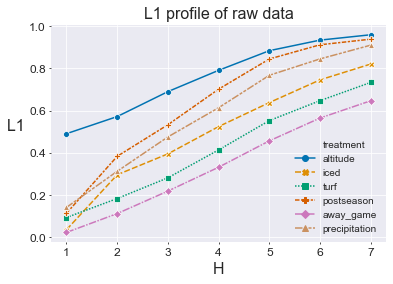

In [201]:
imb = pd.DataFrame.from_records(rows)
imb = imb.loc[imb['L1']<1, :]

ax = sns.lineplot(x='H', y='L1', data=imb, hue='treatment', style='treatment', markers=True)
ax.set_title('L1 profile of raw data', size=16)
ax.set_xlabel('H', size=16)
ax.set_ylabel('L1    ', size=16, rotation='horizontal')
ax.tick_params(labelsize=12, size=2)
plt.savefig('../images/L1.png')

## Without Matching

#### Imbalance

In [284]:
def pp(val):
    # for annotating regression coefficients by significance
    if val<0.01:
        return '***'
    elif val<0.05:
        return '**'
    elif val<0.1:
        return '*'
    return ''

In [12]:
from matching.cem import UnivariateBalance
multi = {}
imb = {}
for t in binary:
    cem = CEM(df, t, 'good', continuous, H=4)
    multi[t] = cem.preimbalance

    ub = cem.univariate_imbalance()
    imb[t] = ub['imbalance'].round(3).astype(str)+ub['P>|z|'].apply(pp) 

df_imb = pd.DataFrame.from_dict(imb, orient='columns')
df_imb = df_imb.append(pd.DataFrame(multi, index=['multivariate']))

In [276]:
print(df_imb.to_latex())

NameError: name 'df_imb' is not defined

#### Regression

* df_unmatched is all covariate estimates for all models.
* results_unmatched is a dict of all statsmodels.Results.

In [235]:
formulas_s = {t:f'good ~ {t}' for t in df.drop('good', axis=1).columns}
formula_0 = {'main effects':'good ~ '+ ' + '.join(df.drop('good', axis=1).columns)}
formula_1 = {'interactions':'good ~ '+ ' + '.join(df.drop('good', axis=1).columns) + f'+ iced*pressure + altitude*distance'}
formula_2 = {'full':'good ~ ' + ' + '.join(df.drop(['good'], axis=1).columns) + f'+ np.log(wind+1) + np.log(seasons) + np.log(distance) + iced*pressure + altitude*distance'}
formulas = {**formulas_s, **formula_0, **formula_1, **formula_2}

In [238]:
df_unmatched = pd.DataFrame(columns=['coef', 'P>|z|', 'bse', 'model'])
results_unmatched = {}
for name, formula in formulas.items():
    glm = smf.glm(formula, data=df, family=sm.families.Binomial())
    result = glm.fit(method='bfgs', maxiter=10000)
    results_unmatched[name] = result
    model = name if name not in df.columns else 'simple'
    df_unmatched = pd.concat((df_unmatched, pd.DataFrame({'coef':result.params, 'P>|z|':result.pvalues, 'bse': result.bse, 'model':model})))

df_unmatched.index.rename('covariate', inplace=True)
df_unmatched = df_unmatched.reset_index('covariate')
results_unmatched = pd.Series(results_unmatched, name='model')

In [142]:
df_unmatched.head()

,covariate,coef,P>|z|,bse,model
0,Intercept,6.091820,0.000000e+00,0.113231,simple
1,distance,-0.108927,0.000000e+00,0.002568,simple
2,Intercept,1.465018,0.000000e+00,0.037945,simple
3,year,0.024866,3.888169e-12,0.003582,simple
4,Intercept,1.563687,0.000000e+00,0.036535,simple


In [239]:
# get the order of covariates so the table looks pretty
order_ = OrderedDict()
for cov in df_unmatched['covariate']:
    if cov != 'Intercept':
        order_[cov] = 1

order_ = list(order_.keys())
order_

['distance',
 'year',
 'seasons',
 'temperature',
 'altitude',
 'wind',
 'away_game',
 'postseason',
 'iced',
 'turf',
 'precipitation',
 'pressure',
 'iced:pressure',
 'altitude:distance',
 'np.log(wind + 1)',
 'np.log(seasons)',
 'np.log(distance)']

In [330]:
df_um = df_unmatched.loc[df_unmatched['covariate']!='Intercept', :]
df_um['coef'] = df_um['coef'].round(3).astype(str) + df_um['P>|z|'].apply(pp)
df_um = df_um.loc[:,['covariate', 'coef', 'model']]
print(df_um.pivot('covariate', columns='model', values='coef').loc[order_, ['simple','main effects', 'interactions', 'full']].to_latex())

\begin{tabular}{lllll}
\toprule
model &     simple & main effects & interactions &       full \\
covariate         &            &              &              &            \\
\midrule
distance          &  -0.109*** &    -0.116*** &    -0.116*** &   -0.041** \\
year              &   0.025*** &     0.041*** &     0.041*** &    0.04*** \\
seasons           &   0.017*** &      0.011** &      0.011** &      0.004 \\
temperature       &   0.006*** &     0.013*** &     0.013*** &   0.013*** \\
altitude          &      0.104 &     0.423*** &        0.433 &      0.626 \\
wind              &  -0.018*** &    -0.016*** &    -0.016*** &  -0.025*** \\
away\_game         &     -0.052 &       -0.019 &       -0.019 &     -0.019 \\
postseason        &     -0.069 &       -0.067 &       -0.067 &     -0.066 \\
iced              &  -0.364*** &      -0.122* &       -0.006 &     -0.026 \\
turf              &   0.206*** &      0.18*** &     0.181*** &   0.198*** \\
precipitation     &  -0.309*** &    -0.253*** 

In [332]:
# SATE estimates for each model for each possible treatment
from scipy.stats import norm
sates = []
for t in binary:
    df_treated = df.copy()
    df_control = df.copy()
    df_treated[t] = 1
    df_control[t] = 0

    for name, result in results_unmatched.items():
        if (name in continuous) or (name in binary and name!=t):
            continue
        # calculate outcomes under treatment or not
        treated_outcome = result.predict(df_treated)
        control_outcome = result.predict(df_control)
        t_mean = treated_outcome.mean()
        c_mean = control_outcome.mean()
        sate = t_mean - c_mean

        # significance test
        pooled = (t_mean+c_mean)/2
        pooled_se = np.sqrt(2*pooled*(1-pooled)/len(df))
        z = sate/pooled_se
        p = norm.sf(abs(z))

        sates.append({'treatment':t, 'model':name if name not in binary else 'simple', 'SATE':str(round(sate,3))+pp(p)})
df_sate = pd.DataFrame.from_records(sates).set_index(['treatment', 'model'])
print(df_sate.round(3).to_latex())
# df_sate.round(3)

\begin{tabular}{lll}
\toprule
              &      &       SATE \\
treatment & model &            \\
\midrule
altitude & simple &   0.013*** \\
              & main effects &   0.043*** \\
              & interactions &   0.043*** \\
              & full &   0.041*** \\
iced & simple &  -0.052*** \\
              & main effects &  -0.014*** \\
              & interactions &  -0.011*** \\
              & full &  -0.013*** \\
turf & simple &   0.027*** \\
              & main effects &    0.02*** \\
              & interactions &    0.02*** \\
              & full &   0.022*** \\
postseason & simple &  -0.009*** \\
              & main effects &   -0.008** \\
              & interactions &   -0.008** \\
              & full &   -0.008** \\
away\_game & simple &   -0.007** \\
              & main effects &     -0.002 \\
              & interactions &     -0.002 \\
              & full &     -0.002 \\
precipitation & simple &  -0.044*** \\
              & main effects &   -0.03*** \\
     

In [314]:
df_cf

,good,distance,year,seasons,temperature,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,
2166,1,38,0,17,22,0,10,1,0,0,1,1,1
2185,1,27,0,17,22,0,10,1,0,0,1,1,1
4565,1,36,0,17,26,0,13,0,0,1,0,1,5
8564,1,24,0,17,16,0,16,1,0,0,1,0,1
8628,1,40,0,17,16,0,16,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,1,30,19,3,18,0,0,0,0,0,0,1,1
865338,1,21,19,3,18,0,11,0,0,0,0,1,2
868268,1,22,19,3,6,0,7,1,0,0,1,1,1


Conditional treatment effects (heterogeneous)

In [240]:
def CATE(result, T, X, X_val):
    result = result.copy()
    result['val'] = result['covariate'].str.replace(':', '*').apply(lambda x: eval(x, {T:1, X:X_val, 'np':np}))
    result['val*beta'] = result['val']*result['coef']
    result.set_index('covariate', inplace=True)
    # print(result)
    cate = result['val*beta'].sum()
    var = {x: vc.loc[x,x] for x in result.index}
    # print(var)
    cov = {(x,y): vc.loc[x, y] for x, y in itertools.combinations(result.index, 2)}
    # print(cov)
    se_var_terms = sum([v*result.loc[k,'val']**2 for k, v in var.items()])
    se_cov_terms = sum([2*result.loc[x,'val']*result.loc[y, 'val']*cv for (x,y), cv in cov.items()])
    se = np.sqrt(se_var_terms + se_cov_terms)
    return cate, se

In [311]:
pairs = (('iced', 'pressure'), ('altitude', 'distance'))
models = ('interactions', 'full')
for (T, M), model in itertools.product(pairs, models):
    vals = range(df[M].min(), df[M].max()+1)

    result = df_unmatched.loc[(df_unmatched['model']==model) & ([T in r for r in df_unmatched['covariate']]), :]
    vc = results_unmatched[model].cov_params()

    ATE, SE = zip(*[CATE(result, T, M, d) for d in vals])


    fig, axes = plt.subplots(2,1)
    sns.distplot(df[M], kde=False, ax=axes[1])
    ax = sns.lineplot(x=vals, y=ATE, ax=axes[0])
    lb = np.array(ATE) - 1.96*np.array(SE)
    ub = np.array(ATE) + 1.96*np.array(SE)
    axes[0].fill_between(vals,lb,ub, alpha=0.3)
    ax.set_title(f'Marginal effect of {T} with {M}')
    axes[1].set_xlabel(M)
    ax.set_ylabel(f'Marginal effect of {T}')
    axes[1].set_ylabel('Count')
    ax.set_xticklabels([])
    ax.hlines(0,df[M].min(), df[M].max(), colors='r', alpha=0.5, linestyles='dashed')
    plt.savefig(f'../images/unmatched_{T}/{M}_{model}.png')
    plt.cla()
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [360]:
pres = df['pressure'].value_counts().sort_index(ascending=True).round(3).to_frame()
pres.index.rename('Level', inplace=True)
pres = pres.rename(columns={'pressure':'Count'})
print(pres.to_latex())

\begin{tabular}{lr}
\toprule
{} &  Count \\
Level &        \\
\midrule
0     &    381 \\
1     &  13814 \\
2     &   3582 \\
3     &     52 \\
4     &     28 \\
5     &    594 \\
6     &    352 \\
\bottomrule
\end{tabular}



### Analysis of Residuals

Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 137 bins.
Using 13

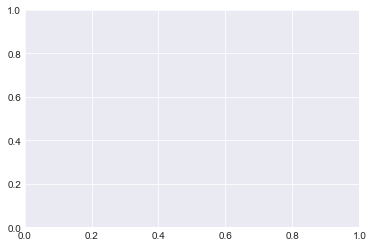

In [285]:
# models = ('main effects', 'interactions', 'full')
models = formulas.keys()
ons = ['pred']+continuous
for model, on in itertools.product(models, ons):
    resid = binned_residuals(results_unmatched[model], df.drop('good', axis=1), df['good'], bins=None, on=on)
    pct = round(resid['inside'].mean()*100,1)
    # print(pct, r'% of train bins mean residuals within bounds.')
    ax = plot_binned_residuals(resid, on=on)
    ax.set_title(f'Binned residuals on {on} for {model} model ({pct}% inside)')
    model = '_'.join(model.split())
    plt.savefig(f'../images/unmatched_residuals/{model}_{on}.png')
    plt.cla()

## With Matching

### Coarsening

In [264]:
def var_plot(data, var, cuts=3, func=pd.cut, bins=None, **kwargs):
    ax = sns.distplot(data[var], kde=False, bins=bins)    
    out, bins = func(data[var], cuts, retbins=True, **kwargs)
    for bin_ in bins:
        plt.axvline(bin_, color='r', linestyle='dashed', linewidth=2)
    return ax, out

In [270]:
coarsening = {
    'distance': {'bins':range(15,86,10), 'cut': 'cut'}, # relax over
    'year': {'bins': 5, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0,4,10,18,30], 'cut': 'cut'},
    'temperature': {'bins': [-25,-5,5,15,25,35,45], 'cut': 'cut'},
    'wind': {'bins': [-0.1,12,25,41], 'cut': 'cut'},
    'pressure': {'bins': 3, 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}

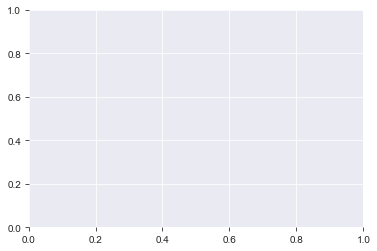

In [269]:
for var, coarsen in coarsening.items():
    cut = coarsen['cut']
    div = 2 if var in ('wind', 'temperature') else 1
    ax, bins = var_plot(df, var, cuts=coarsen['bins'], bins=int(df[var].nunique()/div), func=eval(f'pd.{cut}'))
    ax.tick_params(size=4)
    ax.set_title(f'Coarsening of {var}')
    bins.cat.categories
    plt.savefig(f'../images/coarsening/{var}.png')
    plt.cla()

#### Imbalance

In [102]:
df_imb = None
multi = {}
matched = {}
t_matched = {}
uni = {}
for t in binary:
    cem = CEM(df, t, 'good', continuous, H=4)
    ub = cem.univariate_imbalance(coarsening)
    # print(ub)
    uni[t] = ub['imbalance'].round(3).astype(str)+ub['P>|z|'].apply(pp)
    matched_ = cem.match(coarsening)>0
    matched[t] = matched_.sum()
    t_matched[t] = (df.loc[matched_, t] == 1).sum()/(df[t]==1).sum()*100
    multi[t] = cem.imbalance(coarsening)

df_imb = pd.DataFrame.from_dict(uni, orient='columns')
df_imb = df_imb.append(pd.DataFrame(multi, index=['multivariate']))
df_imb = df_imb.append(pd.DataFrame(matched, index=['% matched'])/len(df)*100)
df_imb = df_imb.append(pd.DataFrame(t_matched, index=['% treatment matched']))
# print(df_imb.to_latex())

In [105]:
print(df_imb.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &  altitude &      iced &      turf & postseason & away\_game & precipitation \\
\midrule
altitude            &       NaN &  0.011*** &       0.0 &   0.026*** &     0.003 &      0.005*** \\
away\_game           &  0.069*** &     0.009 &     0.006 &      0.003 &       NaN &      0.047*** \\
distance            &     0.016 &  0.048*** &    0.016* &      0.034 &     0.011 &         0.008 \\
iced                &  0.044*** &       NaN &   0.009** &   0.065*** &     0.003 &      0.043*** \\
postseason          &  0.029*** &   0.02*** &       0.0 &        NaN &       0.0 &      0.016*** \\
precipitation       &     0.001 &  0.033*** &     0.003 &   0.067*** &     0.005 &           NaN \\
pressure            &     0.031 &  0.094*** &     0.004 &    0.018** &     0.004 &      0.018*** \\
seasons             &      0.01 &     0.011 &  0.038*** &      0.017 &  0.026*** &         0.031 \\
temperature         &   0.14*** &  0.054*** &     0.068 &   0.216*** &  

### Regressions

In [249]:
weights = {t:CEM(df, t, 'good', continuous, H=4).match(coarsening) for t in binary}
drop = {'altitude': ['turf'], 'turf': ['altitude']}

In [250]:
df_matched = pd.DataFrame(columns=['coef', 'P>|z|', 'bse', 'model', 'treatment'])
results_matched = []
models = ['simple', 'main effects', 'interactions', 'full']

for t, model in itertools.product(binary, models):
    if model == 'simple':
        formula = f'good ~ {t}'
    elif model == 'main effects':
        formula = 'good ~ '+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns)
    elif model == 'interactions' and t == 'turf':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) + ' + iced*pressure'
    elif model == 'interactions':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) + ' + iced*pressure + altitude*distance'
    elif model == 'full' and t == 'turf':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) +\
        '+ np.log(wind+1) + np.log(seasons) + iced*pressure'
    elif model == 'full':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) +\
        ' + np.log(wind+1) + np.log(seasons) + np.log(distance) + iced*pressure + altitude*distance'
    # print(t, model)
    # print(formula)
    w = weights[t]
    glm = smf.glm(formula,
                data=df[w > 0],
                family=sm.families.Binomial(),
                var_weights=w[w > 0])
    result = glm.fit(method='bfgs', maxiter=1000)
    results_matched.append({'model': model, 'result':result, 'treatment': t})
    df_matched = pd.concat((df_matched, pd.DataFrame({'coef':result.params, 
                                                      'P>|z|':result.pvalues, 
                                                      'bse': result.bse,
                                                      'model':model, 
                                                      'treatment':t})))

df_matched.index.rename('covariate', inplace=True)
df_matched.reset_index('covariate', inplace=True)
results_matched = pd.DataFrame.from_records(results_matched)

In [213]:
df_matched.head(5)

,covariate,coef,P>|z|,bse,model,treatment
0,Intercept,1.668793,3.994804e-239,0.050537,simple,altitude
1,altitude,0.078904,5.521498e-01,0.132715,simple,altitude
2,Intercept,5.430130,1.101308e-53,0.352021,main effects,altitude
3,distance,-0.107915,5.024400e-63,0.006440,main effects,altitude
4,year,0.054354,2.638426e-09,0.009131,main effects,altitude


In [214]:
results_matched.head(5)

,model,result,treatment
0,simple,<statsmodels.genmod.generalized_linear_model.G...,altitude
1,main effects,<statsmodels.genmod.generalized_linear_model.G...,altitude
2,interactions,<statsmodels.genmod.generalized_linear_model.G...,altitude
3,full,<statsmodels.genmod.generalized_linear_model.G...,altitude
4,simple,<statsmodels.genmod.generalized_linear_model.G...,iced


In [215]:
def expand(row, filter_=False):
    summary = to_frame(row['result'].summary())
    summary['treatment'] = row['treatment']
    if filter_:
        summary = summary.loc[[row['treatment'] in c for c in summary.index]]
    return summary

In [216]:
def drop_unrelated(group):
    t = group['treatment'].iloc[0]
    group = group.loc[group['covariate'].str.contains(t, regex=False)]
    return group

In [217]:
df_m = df_matched.loc[df_matched['covariate']!='Intercept', :]
df_m = df_m.groupby('treatment').apply(drop_unrelated).reset_index(drop=True)
df_m['coef'] = df_m['coef'].round(3).astype(str) + df_m['P>|z|'].apply(pp)
df_m = df_m.loc[:,['covariate', 'coef', 'model', 'treatment']]
df_piv = df_m.pivot_table(index=['treatment','covariate'], columns='model', values='coef', aggfunc=lambda x: x).loc[order_, ['simple','main effects', 'interactions', 'full']]
print(df_piv.to_latex())

\begin{tabular}{llllll}
\toprule
     & model &     simple & main effects & interactions &       full \\
treatment & covariate &            &              &              &            \\
\midrule
altitude & altitude &      0.079 &        0.218 &      1.837** &    2.154** \\
     & altitude:distance &        NaN &          NaN &      -0.037* &   -0.045** \\
away\_game & away\_game &     -0.035 &       -0.008 &       -0.007 &     -0.006 \\
iced & iced &  -0.355*** &    -0.222*** &       -0.075 &     -0.091 \\
     & iced:pressure &        NaN &          NaN &       -0.106 &     -0.099 \\
postseason & postseason &     -0.141 &        0.125 &        0.107 &      0.067 \\
precipitation & precipitation &  -0.305*** &    -0.265*** &    -0.264*** &  -0.255*** \\
turf & turf &   0.158*** &      0.138** &      0.138** &   0.171*** \\
\bottomrule
\end{tabular}



SATE

In [334]:
from scipy.stats import ttest_rel
sates = []

for t in binary:

    # num all units
    n = len(df)

    # num all treated and controls
    n_t = (df[t]==1).sum()
    n_c = (df[t]==0).sum()

    # num matched units
    m = (weights[t]>0).sum()

    # num matched treated and controls
    m_t = len(df.loc[(weights[t]>0) & (df[t]==1),:])
    m_c = len(df.loc[(weights[t]>0) & (df[t]==0),:])

    # matched and unmatched units
    df_m = df.loc[(weights[t]>0), :] # matched
    df_um = df.loc[(weights[t]==0), :] # unmatched

    # matched treated units (observed or counterfactual)
    df_m_treated = df_m.copy()
    df_m_treated[t] = 1

    # matched control units (observed or counterfactual)
    df_m_control = df_m.copy()
    df_m_control[t] = 0

    # unmatched treated units (observed or counterfactual)
    df_um_treated = df_um.copy()
    df_um_treated[t] = 1

    # unmatched control units (observed or counterfactual)
    df_um_control = df_um.copy()
    df_um_control[t] = 0

    for _, row in results_matched.iterrows():
        result = row['result']

        if row['treatment'] != t:
            continue

        # matched predictions
        treated_m = result.predict(df_m_treated)
        control_m = result.predict(df_m_control)

        # unmatched predictions
        treated_um = result.predict(df_um_treated)
        control_um = result.predict(df_um_control)

        # sate for matched and unmatched units and their counterfactuals
        sate_m = (treated_m-control_m).mean().round(3)
        sate_um = (treated_um-control_um).mean().round(3)

        # weighted sate combining matched and unmatched sates
        sate_w = round((sate_m*m + sate_um*(n-m))/n,3)

        # significance test for matched
        pooled_m = (treated_m.mean() + control_m.mean())/2
        pooled_var_m = 2*pooled_m*(1-pooled_m)/m
        pooled_se_m = np.sqrt(pooled_var_m)
        z_m = sate_m/pooled_se_m
        p_m = norm.sf(abs(z_m))

        # significance test for unmatched
        pooled_um = (treated_um.mean() + control_um.mean())/2
        pooled_var_um = 2*pooled_um*(1-pooled_um)/(n-m)
        pooled_se_um = np.sqrt(pooled_var_um)
        z_um = sate_um/pooled_se_um
        p_um = norm.sf(abs(z_um))

        # weighted significance test
        pooled_var_w = (pooled_var_m*m + pooled_var_um*(n-m))/n
        pooled_se_w = np.sqrt(pooled_var_w)
        z_w = sate_w/pooled_se_w
        p_w = norm.sf(abs(z_w))

        sates.append({'treatment':t, 'model':row['model'], 'local SATE':str(sate_m)+pp(p_m), 'unmatched SATE':str(sate_um)+pp(p_um), 'weighted SATE':str(sate_w)+pp(p_w)})
df_sate = pd.DataFrame.from_records(sates).set_index(['treatment', 'model'])

In [336]:
print(df_sate.to_latex())

\begin{tabular}{lllll}
\toprule
              &      & local SATE & unmatched SATE & weighted SATE \\
treatment & model &            &                &               \\
\midrule
altitude & simple &       0.01 &        0.01*** &        0.01** \\
              & main effects &   0.024*** &       0.025*** &      0.025*** \\
              & interactions &   0.025*** &       0.027*** &      0.027*** \\
              & full &   0.021*** &       0.024*** &      0.023*** \\
iced & simple &   -0.05*** &       -0.05*** &      -0.05*** \\
              & main effects &  -0.026*** &      -0.025*** &     -0.026*** \\
              & interactions &  -0.025*** &      -0.028*** &     -0.026*** \\
              & full &  -0.026*** &      -0.028*** &     -0.027*** \\
turf & simple &    0.02*** &        0.02*** &       0.02*** \\
              & main effects &   0.015*** &        0.017** &      0.015*** \\
              & interactions &   0.015*** &        0.017** &      0.015*** \\
              & full 

#### SATT

In [218]:
from scipy.stats import ttest_rel
satts = []

for t in binary:

    # all units
    nT = (df[t]==1).sum()

    # matched and unmatched treated units
    df_t_m = df.loc[(weights[t]>0) & (df[t]==1), :] # matched
    df_t_um = df.loc[(weights[t]==0) & (df[t]==1), :] # unmatched

    # observed outcomes for matched and unmatched treated units
    observed_m = df_t_m['good']
    observed_um = df_t_um['good']
    mT = len(observed_m) # matched treated units

    # counterfactual data points for matched treated units
    df_cf_m = df_t_m.copy()
    df_cf_m[t] = 0

    # counterfactuals for unmatched treated units
    df_cf_um = df_t_um.copy()
    df_cf_um[t] = 0

    for _, row in results_matched.iterrows():
        result = row['result']

        if row['treatment'] != t:
            continue

        # true predictions
        true_m = result.predict(df_t_m)
        true_um = result.predict(df_t_um)

        # potential outcome for matched and unmatched treated unit counterfactuals
        potential_m = result.predict(df_cf_m)
        potential_um = result.predict(df_cf_um)

        # satt for matched and unmatched treated units and their counterfactuals
        satt_m = (true_m-potential_m).mean().round(3)
        satt_um = (true_um-potential_um).mean().round(3)

        # weighted satt combining matched and unmatched satts
        satt_w = round((satt_m*mT + satt_um*(nT-mT))/nT,3)

        # t-test for matched and unmatched treated units and their counterfactuals. THIS IS POTENTIALLY VERY WRONG!
        stat_m, p_m = ttest_rel(observed_m, potential_m)
        stat_um, p_um = ttest_rel(observed_um, potential_um)
        p_w = (p_m*mT + p_um*(nT-mT))/nT

        satts.append({'treatment':t, 'model':row['model'], 'local satt':str(satt_m)+pp(p_m), 'unmatched satt':str(satt_um)+pp(p_um), 'weighted satt':str(satt_w)+pp(p_w)})
df_satt = pd.DataFrame.from_records(satts).set_index(['treatment', 'model'])

In [219]:
print(df_satt.to_latex())

\begin{tabular}{lllll}
\toprule
              &      & local satt & unmatched satt & weighted satt \\
treatment & model &            &                &               \\
\midrule
altitude & simple &       0.01 &           0.01 &          0.01 \\
              & main effects &    0.025** &       0.032*** &       0.027** \\
              & interactions &    0.023** &       0.019*** &       0.022** \\
              & full &     0.018* &        0.01*** &        0.016* \\
iced & simple &   -0.05*** &       -0.05*** &      -0.05*** \\
              & main effects &   -0.028** &      -0.029*** &      -0.028** \\
              & interactions &   -0.029** &      -0.064*** &      -0.038** \\
              & full &    -0.03** &      -0.063*** &      -0.039** \\
turf & simple &    0.02*** &           0.02 &        0.02** \\
              & main effects &   0.015*** &        0.017** &      0.015*** \\
              & interactions &   0.015*** &        0.016** &      0.015*** \\
              & full 

Conditional Treatment Effect

In [312]:
pairs = (('iced', 'pressure'), ('altitude', 'distance'))
models = ('interactions', 'full')
for (T, M), model in itertools.product(pairs, models):
    vals = range(df[M].min(), df[M].max()+1)

    result = df_matched.loc[(df_matched['model']==model) & (df_matched['treatment']==T) & ([T in r for r in df_matched['covariate']]), :]
    vc = results_matched.loc[(results_matched['model']==model) & (results_matched['treatment']==T), 'result'].iloc[0].cov_params()

    ATE, SE = zip(*[CATE(result, T, M, d) for d in vals])

    fig, axes = plt.subplots(2,1)
    sns.distplot(df.loc[weights[T]>0, M], kde=False, ax=axes[1])
    ax = sns.lineplot(x=vals, y=ATE, ax=axes[0])
    lb = np.array(ATE) - 1.96*np.array(SE)
    ub = np.array(ATE) + 1.96*np.array(SE)
    axes[0].fill_between(vals,lb,ub, alpha=0.3)
    ax.set_title(f'Marginal effect of {T} with {M}')
    axes[1].set_xlabel(M)
    ax.set_ylabel(f'Marginal effect of {T}')
    axes[1].set_ylabel('Count')
    ax.set_xticklabels([])
    ax.hlines(0,df[M].min(), df[M].max(), colors='r', alpha=0.5, linestyles='dashed')
    plt.savefig(f'../images/matched_{T}/{M}_{model}.png')
    plt.cla()
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [359]:
pres = df.loc[weights['iced']>0,'pressure'].value_counts().sort_index(ascending=True).round(3).to_frame()
pres.index.rename('Level', inplace=True)
pres = pres.rename(columns={'pressure':'Count'})
print(pres.to_latex())

\begin{tabular}{lr}
\toprule
{} &  Count \\
Level &        \\
\midrule
0     &    244 \\
1     &   8216 \\
2     &   2197 \\
3     &      1 \\
4     &      1 \\
5     &    186 \\
6     &    108 \\
\bottomrule
\end{tabular}



Residuals

Using 58 bins.


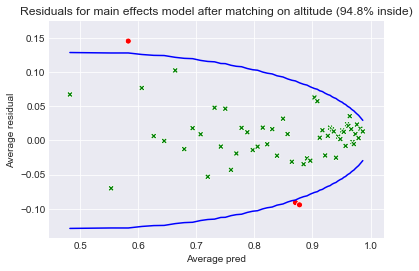

Using 104 bins.


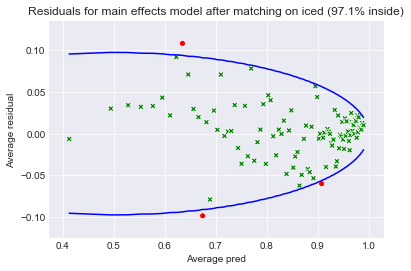

Using 119 bins.


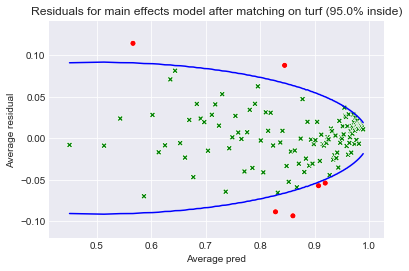

Using 70 bins.


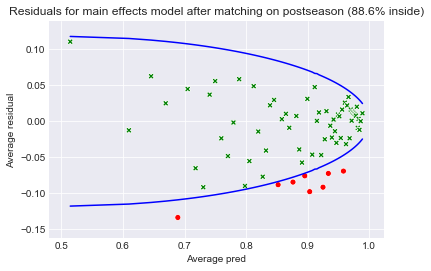

Using 122 bins.


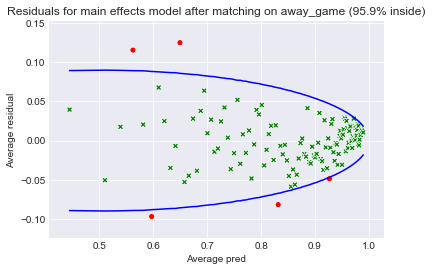

Using 89 bins.


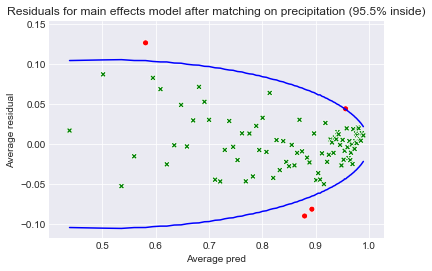

Using 58 bins.


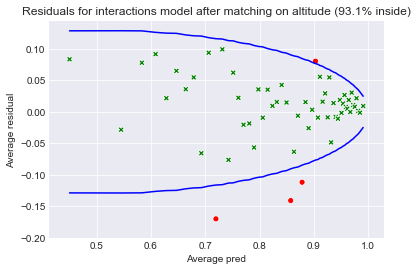

Using 104 bins.


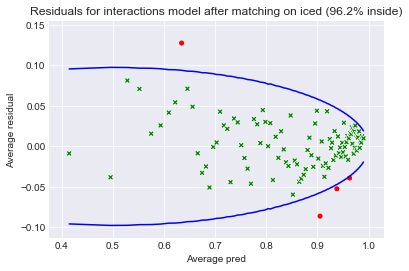

Using 119 bins.


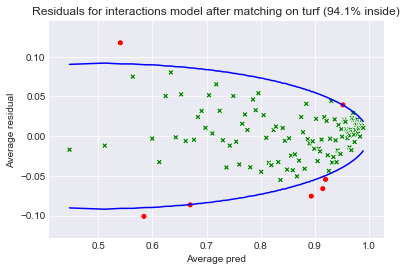

Using 70 bins.


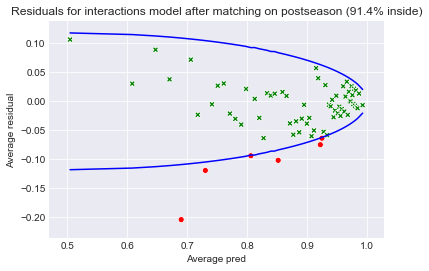

Using 122 bins.


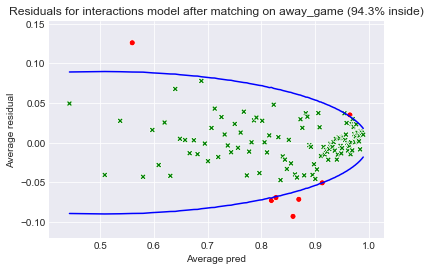

Using 89 bins.


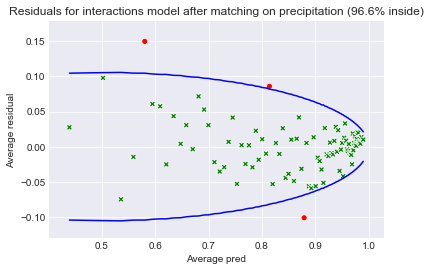

Using 58 bins.


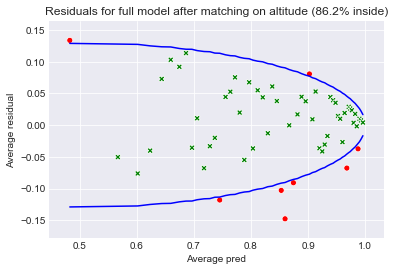

Using 104 bins.


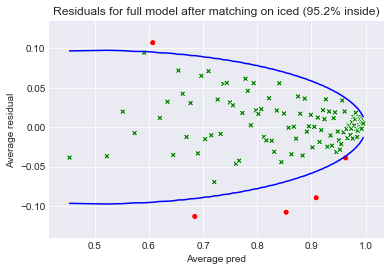

Using 119 bins.


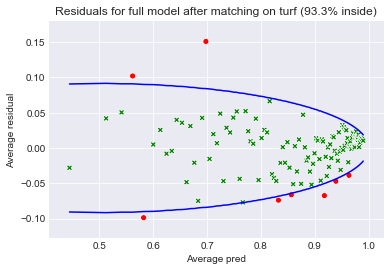

Using 70 bins.


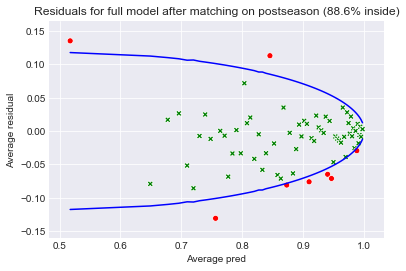

Using 122 bins.


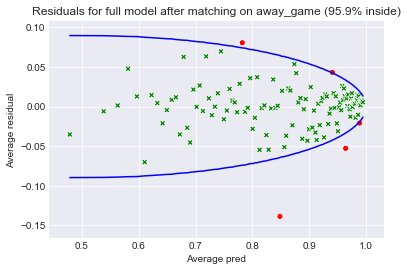

Using 89 bins.


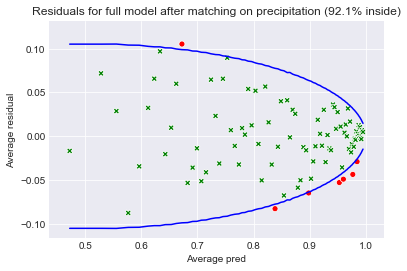

In [274]:
models = ('main effects', 'interactions', 'full')
for model, t in itertools.product(models, binary):
    on = 'pred'
    df_ = df.loc[weights[t]>0, :] # matched
    resid = binned_residuals(results_matched.loc[(results_matched['model']==model) & (results_matched['treatment']==t), 'result'].iloc[0], df_.drop('good', axis=1), df_['good'], bins=None, on=on)
    pct = round(resid['inside'].mean()*100,1)
    # print(pct, r'% of train bins mean residuals within bounds.')
    ax = plot_binned_residuals(resid, on=on)
    ax.set_title(f'Residuals for {model} model after matching on {t} ({pct}% inside)')
    model = '_'.join(model.split())
    plt.savefig(f'../images/matched_residuals/{model}_{t}_{on}.png')
    plt.show()